# “Análisis de la pobreza en el Perú por el nivel de ingresos e informalidad”

* Análisis de la evolución de la pobreza y bienestar de los hogares en Perú utilizando data de ENAHO 2022.

👉 módulo (Enaho01a-2022-500) ingresos - empleo
👉 módulo (Enaho01a-2022-400) salud
👉 módulo (Enaho01a-2022-300) educación

* Se usará Python (Pandas, NumPy, Matplotlib, Seaborn) para analizar más de 87 000 registros sobre empleo e ingresos de Perú (2022).

* Se hará una limpieza de datos para manejar valores faltantes, duplicados y valores atípicos, asegurando la integridad de los datos para el análisis.

* Se generará visualizaciones y análisis estadístico para identificar disparidades en los ingresos entre las áreas rurales y urbanas, destacando una brecha significativa de ingresos entre las áreas rurales y rurales.

## 1. Entendimiento del proyecto
### Objetivo : 
*   Evaluar la pobreza por ingresos en el Perú(2022) en base a las variables proporcionadas

### Hipótesis:
* Un aumento en el nivel de ingresos incide negativamente en la pobreza por ingresos.

#### Variables clave:

* Ingreso relacionado: ingreso_total.
* Variables de ocupación: ocupacion_principal, trabajo_ocup_principal, tipo_contrato, ocupacion_formalidad.
* Información sociodemográfica: estrato, dominio, zonas, ubigeo.
Temporalidad: mes.

### Método estadístico de análisis:
*   Se utilizará el método de correlación para evaluar la relación entre las variables ingresos y pobreza.


In [73]:
#Importamos las librerías necesarias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')


📌 Los datos son descargados de la web oficial de ENAHO(Encuesta Nacional de hogares) - INEI (Instituto Nacional de Estadística e Informática) 2022

👉👉 https://www.datosabiertos.gob.pe/dataset/encuesta-nacional-de-hogares-enaho-2022-instituto-nacional-de-estad%C3%ADstica-e-inform%C3%A1tica-%E2%80%93

📌 Descargar el módulo ingresos y empleo (Enaho01a-2022-500) directo aquí:👇👇

✅ https://github.com/WLozanoH/Poverty-Peru/blob/main/Enaho01a-2022-500.zip

In [74]:
#CARGAMOS SOLO LA DATA A ANALIZAR

df = pd.read_csv('Enaho01a-2022-500.csv', sep=',', usecols=['MES','NCONGLOME','VIVIENDA','HOGAR','CODPERSO','UBIGEO','DOMINIO','ESTRATO',
                                                            'P507','P510','P510A1',
                                                            'P511A','P524A1','OCUPINF'],
                 na_values= [' ', 999999])
df.head()


,MES,VIVIENDA,HOGAR,CODPERSO,UBIGEO,DOMINIO,ESTRATO,P507,P510,P510A1,P511A,P524A1,OCUPINF,NCONGLOME
0,2,3,11,1,10101,4,4,3.0,2.0,NaN,1.0,5000.0,2.0,7070
1,2,12,11,1,10101,4,4,4.0,6.0,2.0,7.0,800.0,1.0,7070
2,2,22,11,1,10101,4,4,3.0,2.0,NaN,1.0,1660.0,2.0,7070
3,2,22,11,2,10101,4,4,3.0,2.0,NaN,1.0,2300.0,2.0,7070
4,2,22,11,3,10101,4,4,2.0,NaN,3.0,NaN,NaN,1.0,7070


📌 Renombrando las variables del DataFrame para mejor manipulación de los datos

In [75]:
#Renombrando las variables
df.rename(columns={'P507':'ocupacion_principal',
                   'P510':'trabajo_ocup_principal',
                   'P510A1':'registro_sunat',
                   'P511A':'tipo_contrato',
                   'P524A1':'ingreso_total',
}, inplace=True)

#vivienda: Identificador de vivienda
#hogar: Identificador de hogar
#codperso: Identificador de persona

In [76]:
#Estandarizando los nombres de las columnas: todas a minúscula
df.columns = [col.lower() for col in df]

In [77]:
#Información general del conjunto de datos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87661 entries, 0 to 87660
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   mes                     87661 non-null  int64  
 1   vivienda                87661 non-null  int64  
 2   hogar                   87661 non-null  int64  
 3   codperso                87661 non-null  int64  
 4   ubigeo                  87661 non-null  int64  
 5   dominio                 87661 non-null  int64  
 6   estrato                 87661 non-null  int64  
 7   ocupacion_principal     65240 non-null  float64
 8   trabajo_ocup_principal  25050 non-null  float64
 9   registro_sunat          58720 non-null  float64
 10  tipo_contrato           37511 non-null  float64
 11  ingreso_total           25343 non-null  float64
 12  ocupinf                 61181 non-null  float64
 13  nconglome               87661 non-null  int64  
dtypes: float64(6), int64(8)
memory usage: 

## 2. Limpieza de datos
### 2.1. Estandarizando los valores de todas las variables

📌 Crear un diccionario para darle nombre a la subclasificación del Dominio Geográfico

In [78]:
#crear un diccionario para Dominio Geográfico, 
# variable = 'DOMINIO' para  almacenar los datos de cada región
dominio_geográfico = {
    1: 'Costa Norte',
    2: 'Costa Centro',
    3: 'Costa Sur',
    4: 'Sierra Norte',
    5: 'Sierra Centro',
    6: 'Sierra Sur',
    7: 'Selva',
    8: 'Lima Metropolitana'
}

#Reemplazar los valores numéricos por los nombres de dominio geográfico
df['dominio'] = df['dominio'].map(dominio_geográfico)


📌 Crear un diccionario para estrato la subclasificación de estrato geográfico - se determina las zonas urbanas y rurales


In [79]:
#Crear un diccionario para estrato geográfico
#Área de Empadronamiento Rural = AER
estrato_geografico = {
    
    1: "500,000 a más", 
    2: "100,000 a 499,999", 
    3: "50,000 a 99,999", 
    4: "20,000 a 49,999",
    5: "2,000 a 19,999", 
    6: "500 a 1,999", 
    7: "AER Compuesto",
    8: "AER Simple"
    
}

df['estrato'] = df['estrato'].map(estrato_geografico)

#### Análisis de ocupación principal

In [80]:
# Análisis de 'ocupacion_principal'

ocupaciones = {
    
    1.0:'empleador',
    2.0:'independiente',
    3.0: 'empleado',
    4.0: 'obrero',
    5.0: 'no remunerado',
    6.0: 'trab. hogar',
    7.0: 'otro'
}

#reemplazamos los valores en la variable 'ocupacion_principal'
df['ocupacion_principal'] = df['ocupacion_principal'].map(ocupaciones)

#revisamos valores en:
print(df['ocupacion_principal'].info())
print(df['ocupacion_principal'].value_counts(dropna=False))

<class 'pandas.core.series.Series'>
RangeIndex: 87661 entries, 0 to 87660
Series name: ocupacion_principal
Non-Null Count  Dtype 
--------------  ----- 
65240 non-null  object
dtypes: object(1)
memory usage: 685.0+ KB
None
ocupacion_principal
independiente    25254
NaN              22421
obrero           12697
empleado         12042
no remunerado    11628
empleador         2208
trab. hogar       1100
otro               311
Name: count, dtype: int64


In [81]:
#Análisis de variable 'trabajo_ocup_principal':

trabajos = {
    
    1.0:'Emp.pública',
    2.0:'Emp.pública',
    3.0:'Emp.pública',
    4.0:'emp.privada',
    5.0:'Emp.privada',
    6.0:'otra'

}

#reemplazamos los valores en la variable 'trabajo_ocup_principal'
df['trabajo_ocup_principal'] = df['trabajo_ocup_principal'].map(trabajos)

#revisamos valores en:
print(df['trabajo_ocup_principal'].info())

print(df['trabajo_ocup_principal'].value_counts(dropna=False))


<class 'pandas.core.series.Series'>
RangeIndex: 87661 entries, 0 to 87660
Series name: trabajo_ocup_principal
Non-Null Count  Dtype 
--------------  ----- 
25050 non-null  object
dtypes: object(1)
memory usage: 685.0+ KB
None
trabajo_ocup_principal
NaN            62611
otra           19223
Emp.pública     5420
Emp.privada      407
Name: count, dtype: int64


In [82]:
#variable 'registros_sunat'

#crear un diccionario para mapear datos de registro_sunat
registros_sunat = {
    
    1.0:'persona jurídica',
    2.0:'persona natural',
    3.0: 'no está registrado',
}

#reemplazamos los valores en la variable 'registro_sunat'
df['registro_sunat'] = df['registro_sunat'].map(registros_sunat)

df['registro_sunat'] = df['registro_sunat'].replace({'persona natural':'formal', 'persona jurídica':'formal', 'no está registrado':'informal'})
print(df['registro_sunat'].info())

print(df['registro_sunat'].value_counts(dropna=False))

<class 'pandas.core.series.Series'>
RangeIndex: 87661 entries, 0 to 87660
Series name: registro_sunat
Non-Null Count  Dtype 
--------------  ----- 
58720 non-null  object
dtypes: object(1)
memory usage: 685.0+ KB
None
registro_sunat
informal    43786
NaN         28941
formal      14934
Name: count, dtype: int64


In [83]:
#Creamos una variable 'informalidad' a partir de las variables 'ocupinf' y 'registros_sunat'
df['ocupinf'] = df['ocupinf'].replace({1.0: 'informal', 2.0: 'formal'})

print(df['ocupinf'].info())
print(df['ocupinf'].value_counts(dropna=False))

<class 'pandas.core.series.Series'>
RangeIndex: 87661 entries, 0 to 87660
Series name: ocupinf
Non-Null Count  Dtype 
--------------  ----- 
61181 non-null  object
dtypes: object(1)
memory usage: 685.0+ KB
None
ocupinf
informal    48339
NaN         26480
formal      12842
Name: count, dtype: int64


In [84]:
#Crear una sola variable para medir la informalidad
df['ocupacion_formalidad'] = df['registro_sunat'].fillna(df['ocupinf'])

print(df['ocupacion_formalidad'].info())

print(df['ocupacion_formalidad'].value_counts(dropna=False))

<class 'pandas.core.series.Series'>
RangeIndex: 87661 entries, 0 to 87660
Series name: ocupacion_formalidad
Non-Null Count  Dtype 
--------------  ----- 
65240 non-null  object
dtypes: object(1)
memory usage: 685.0+ KB
None
ocupacion_formalidad
informal    45990
NaN         22421
formal      19250
Name: count, dtype: int64


In [85]:
#Eliminamos las variables 'ocupinf' y 'registro_sunat'
df.drop(columns=['ocupinf','registro_sunat'], inplace=True)

In [86]:
# Análisis de la variable 'tipo_contrato' = el tipo de contrato que tiene la persona donde está laborando

#mapeando valores para 'tipo_contrato'
tipos_contratos = {
    
    1:'permanente',
    2:'temporal',
    3: 'temporal',
    4: 'prácticas',
    5: 'servicios',
    6: 'Adm.pública',
    7: 'servicios',
}

#reemplazamos los valores en la variable 'tipo_contrato'
df['tipo_contrato'] = df['tipo_contrato'].map(tipos_contratos)

#revisamos valores en:
print(df['tipo_contrato'].info())
print(df['tipo_contrato'].value_counts())

<class 'pandas.core.series.Series'>
RangeIndex: 87661 entries, 0 to 87660
Series name: tipo_contrato
Non-Null Count  Dtype 
--------------  ----- 
37510 non-null  object
dtypes: object(1)
memory usage: 685.0+ KB
None
tipo_contrato
servicios      26755
temporal        6171
permanente      3753
Adm.pública      689
prácticas        142
Name: count, dtype: int64


📌 Analizamos la variable "ESTRATO" para clasificar la muestra en URBANO y RURAL

    'AER' = Área de empadronamiento RURAL

In [87]:
#Creando la variable 'ZONAS' para identificar la muestra urbana y rural
df['zonas'] = df['estrato']
#clasificamos la variable 'urbana' y 'rural' usando lambda
df['zonas'] = df['zonas'].apply(lambda x:'rural' if x == 'AER Simple' or  x == 'AER Compuesto' else 'urbano')

In [88]:
# Porcentaje de la muetra total para la zona urbana y rural
print((df['zonas'].value_counts(normalize=True) *100).round(2))

zonas
urbano    72.38
rural     27.62
Name: proportion, dtype: float64


In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87661 entries, 0 to 87660
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   mes                     87661 non-null  int64  
 1   vivienda                87661 non-null  int64  
 2   hogar                   87661 non-null  int64  
 3   codperso                87661 non-null  int64  
 4   ubigeo                  87661 non-null  int64  
 5   dominio                 87661 non-null  object 
 6   estrato                 87661 non-null  object 
 7   ocupacion_principal     65240 non-null  object 
 8   trabajo_ocup_principal  25050 non-null  object 
 9   tipo_contrato           37510 non-null  object 
 10  ingreso_total           25343 non-null  float64
 11  nconglome               87661 non-null  int64  
 12  ocupacion_formalidad    65240 non-null  object 
 13  zonas                   87661 non-null  object 
dtypes: float64(1), int64(6), object(7)
mem

### 2.2. Completando valores nulos

In [90]:
#verificando valores nulos
total_valores_nulos = df.isnull().sum()
porcentaje_valores_nulos = ((total_valores_nulos/len(df)) *100).round(2)

#creamos un dataframe para mostrar solo resultados nulos
resultado_nulos = pd.DataFrame({'total_nulos':total_valores_nulos,'Porcentaje Nulos(%)':porcentaje_valores_nulos})
print(resultado_nulos)

                        total_nulos  Porcentaje Nulos(%)
mes                               0                 0.00
vivienda                          0                 0.00
hogar                             0                 0.00
codperso                          0                 0.00
ubigeo                            0                 0.00
dominio                           0                 0.00
estrato                           0                 0.00
ocupacion_principal           22421                25.58
trabajo_ocup_principal        62611                71.42
tipo_contrato                 50151                57.21
ingreso_total                 62318                71.09
nconglome                         0                 0.00
ocupacion_formalidad          22421                25.58
zonas                             0                 0.00


#### Ninguna variable tiene un porcentaje de valores Nan menores o iguales a 5%, así que pasamos a imputarlos con medidas estadísticas

*   Para variables categóricas, imputamos el valor más común (moda)
*   Para variables numéricas, imputamos la mediana

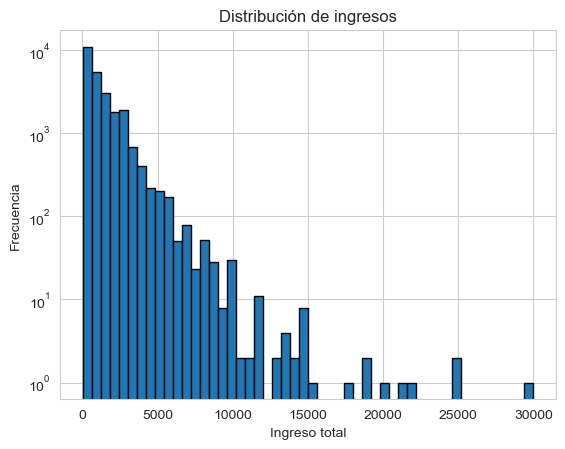

In [91]:
df['ingreso_total'].plot(kind='hist', bins=50, edgecolor='black', log=True)
plt.title('Distribución de ingresos')
plt.xlabel('Ingreso total')
plt.ylabel('Frecuencia')
plt.show()

In [92]:
#Analizando la variable 'ingreso_total'
df['ingreso_total'].describe()

count    25343.000000
mean      1240.874009
std       1441.637968
min          1.000000
25%        280.000000
50%        900.000000
75%       1700.000000
max      30000.000000
Name: ingreso_total, dtype: float64

Completamos valores Nan en la variable 'ingreso_total' agrupando por conglomerado y usando la mediana, dado que es una técnica estadística más precisa cuando hay alta dispersión de valores, en este caso muy extremos, siendo el mínimo 1 y el máximo 30000.


#### Agrupamos por 'nconglome', que agrupa subconjuntos de las localidades donde se realizaron las encuestas a nivel nacional.

In [93]:
#Imputar variables numéricas con la mediana por 'nconglome': usamos la mediana debido al sesgo en los datos.

# Paso 1: Agrupar por 'nconglome' obtener la mediana y convertirlo a diccionario
ingreso_total_dict = df.groupby(['nconglome'])['ingreso_total'].median().to_dict()

# Paso 2: Completar los valores Nan en ingreso total con la mediana usando el diccionario creado.
df['ingreso_total'] = df['ingreso_total'].fillna(df['nconglome'].map(ingreso_total_dict))

print(df.isna().sum())

mes                           0
vivienda                      0
hogar                         0
codperso                      0
ubigeo                        0
dominio                       0
estrato                       0
ocupacion_principal       22421
trabajo_ocup_principal    62611
tipo_contrato             50151
ingreso_total              3362
nconglome                     0
ocupacion_formalidad      22421
zonas                         0
dtype: int64


In [94]:
# Imputar variables categóricas con la moda por 'nconglome'

#Listar variables categóricas que faltan 
categorical_vars = ['ocupacion_principal','trabajo_ocup_principal','tipo_contrato','ocupacion_formalidad']

for var in categorical_vars:
    #Paso1: Agrupar por 'nconglome' y obtener la moda
    mode_dict = df.groupby('nconglome')[var].agg(lambda x: x.mode()[0] if not x.mode().empty else None).to_dict()
    
    #Paso2: Imputar la moda en los valores faltantes
    df[var] = df[var].fillna(df['nconglome'].map(mode_dict))
    
#Verificar los valores faltantes
print(df.isna().sum())

mes                          0
vivienda                     0
hogar                        0
codperso                     0
ubigeo                       0
dominio                      0
estrato                      0
ocupacion_principal          2
trabajo_ocup_principal    3189
tipo_contrato               96
ingreso_total             3362
nconglome                    0
ocupacion_formalidad         2
zonas                        0
dtype: int64


In [95]:
#Los valores Nan restantes procedemos a eliminarlos
print(f'# filas antes de eliminar los Nan restantes: {df.shape[0]}')
df.dropna(inplace=True)
print(f'# filas después de eliminar los Nan restantes: {df.shape[0]}')

# filas antes de eliminar los Nan restantes: 87661
# filas después de eliminar los Nan restantes: 84055


### 2.2. Manejo de valores duplicados

In [96]:
#Verificar duplicados exactos en todo el DataFrame
duplicados_exactos = df[df.duplicated()].shape[0]
print(f'La cantidad de duplicados exactos en el DataFrame es: {duplicados_exactos}')

#Eliminado valores duplicados
print(f'# de filas antes de eliminar duplicados: {df.shape[0]}')
df.drop_duplicates(inplace=True)
print(f'# de filas después de eliminar duplicados: {df.shape[0]}')

La cantidad de duplicados exactos en el DataFrame es: 1
# de filas antes de eliminar duplicados: 84055
# de filas después de eliminar duplicados: 84054


### 2.3. Eliminando valores atípicos

#### Agrupar por nconglomerado y eliminar valores atípicos utilizando el IQR(Rango intercuartil)

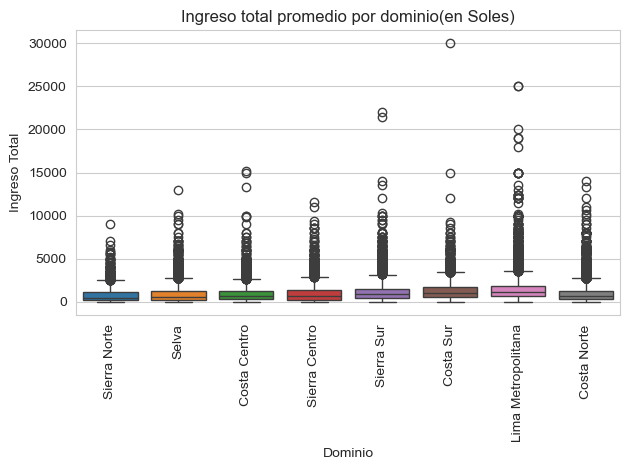

count    84054.000000
mean      1050.765972
std       1080.656330
min          1.000000
25%        300.000000
50%        800.000000
75%       1400.000000
max      30000.000000
Name: ingreso_total, dtype: float64


In [97]:
#Gráfico de los ingresos promedio mensual por dominio antes de eliminar outliers
sns.boxplot(data=df, x='dominio', y='ingreso_total', hue = 'dominio')

#Título y ejes
plt.title('Ingreso total promedio por dominio(en Soles)')
plt.xlabel('Dominio')
plt.ylabel('Ingreso Total')
plt.xticks(rotation = 90)

#Ajustamos el gráfico y lo mostramos
plt.tight_layout()
plt.show()

print(df['ingreso_total'].describe())

In [98]:
# Calcular IQR por nconglomerado
def eliminar_outliers(grupo):
    Q1 = grupo['ingreso_total'].quantile(0.25)
    Q3 = grupo['ingreso_total'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return grupo[(grupo['ingreso_total'] >= lower_bound) & (grupo['ingreso_total'] <= upper_bound)]

# Aplicar a cada conglomerado
df_sin_outliers = df.groupby('nconglome').apply(eliminar_outliers).reset_index(drop=True)

print(f'Numero de filas con outliers: {df.shape[0]}')
print(f'Numero de filas sin outliers: {df_sin_outliers.shape[0]}')

Numero de filas con outliers: 84054
Numero de filas sin outliers: 63829


Hay 96 valores mayores a 6'000 soles.


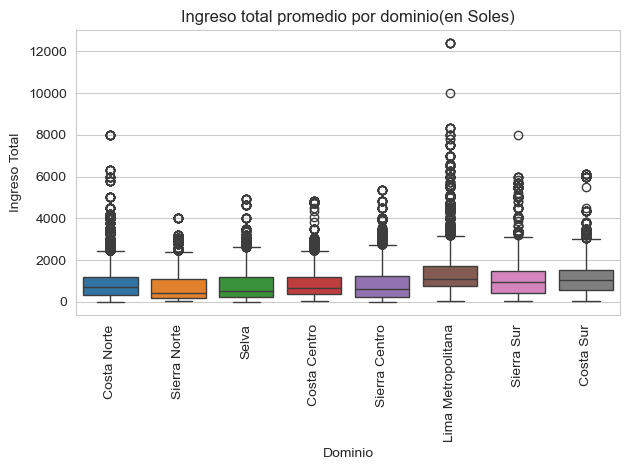

count    63829.000000
mean       971.923138
std        874.749614
min          5.000000
25%        300.000000
50%        790.000000
75%       1308.000000
max      12380.000000
Name: ingreso_total, dtype: float64


In [99]:
#Cantidad de datos mayores a 6'000 soles
tamaño_valores_mas_10000 = df_sin_outliers[(df_sin_outliers['ingreso_total'] > 6000)].shape[0]
print(f"Hay {tamaño_valores_mas_10000} valores mayores a 6'000 soles.")

#Gráfico de los ingresos promedio mensual por dominio después de eliminar outliers
sns.boxplot(data=df_sin_outliers, x='dominio', y='ingreso_total', hue = 'dominio')

#Título y ejes
plt.title('Ingreso total promedio por dominio(en Soles)')
plt.xlabel('Dominio')
plt.ylabel('Ingreso Total')
plt.xticks(rotation = 90)

#Ajustamos el gráfico y lo mostramos
plt.tight_layout()
plt.show()

print(df_sin_outliers['ingreso_total'].describe())

Hemos eliminado valores atípicos usando el rango intercuartil(IQR), ahora observamos que el valor máximo en el ingreso total a disminuído a 12'380, y además solo hay 5 personas con ingresos mayores a 10'000 soles.

### 3. Análisis de la distribución

#### 3.1. Distribución de variables numéricas: 'ingreso_total'

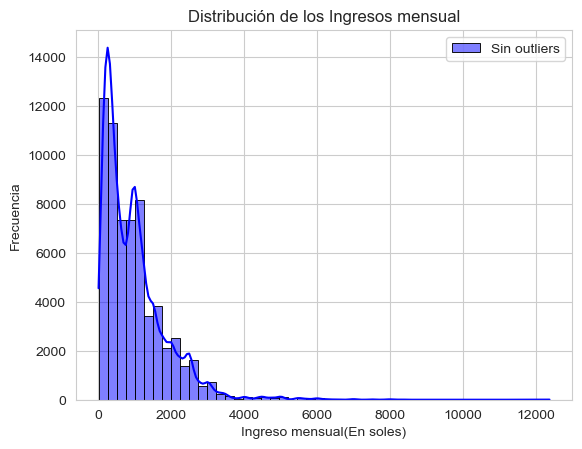

In [100]:
sns.histplot(data=df_sin_outliers, x='ingreso_total', bins=50, edgecolor='black',
             kde=True, color='blue', label='Sin outliers')

plt.title('Distribución de los Ingresos mensual')
plt.xlabel('Ingreso mensual(En soles)')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

In [101]:
df_sin_outliers['ingreso_total'].describe()

count    63829.000000
mean       971.923138
std        874.749614
min          5.000000
25%        300.000000
50%        790.000000
75%       1308.000000
max      12380.000000
Name: ingreso_total, dtype: float64

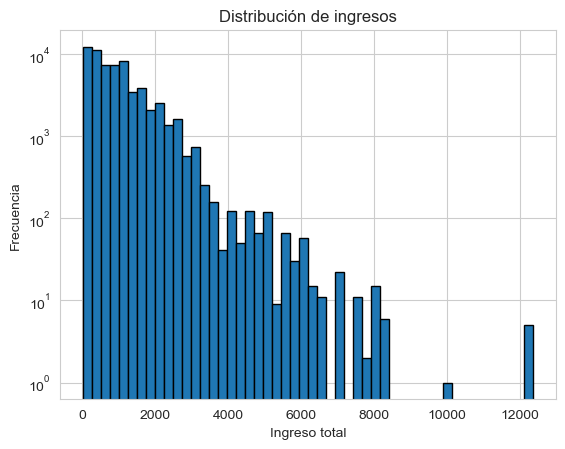

In [102]:
df_sin_outliers['ingreso_total'].plot(kind='hist', bins=50, edgecolor='black', log=True)
plt.title('Distribución de ingresos')
plt.xlabel('Ingreso total')
plt.ylabel('Frecuencia')
plt.show()

Observamos asímetría positiva con sesgo hacia la derecha(ingresos altos), dado que la mayor parte de los ingresos(75%) están concentrados en valores más bajos(inferiores a 2'000 soles).

Hay un pequeño grupo de personas con ingresos significativamente mayores en comparación con la mayoría, lo que indica una distribución desigualdad de los ingresos. 

La mayor densidad para todos los dominios ocurre en valores bajos de ingresos (menores a 2000 soles), reflejando que la mayoría de la población tiene ingresos moderados o bajos.

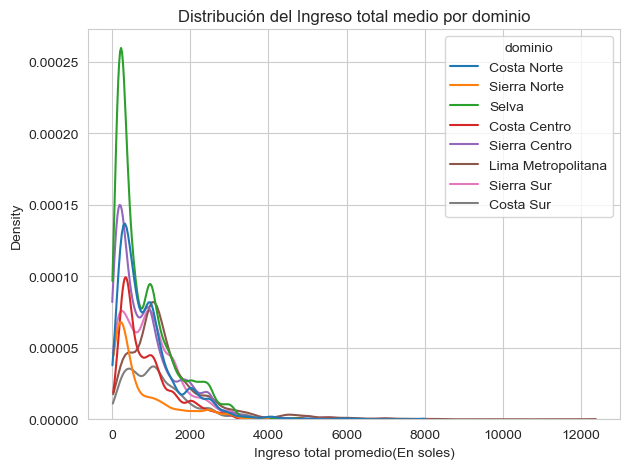

In [103]:
sns.kdeplot(data=df_sin_outliers, x='ingreso_total', hue='dominio',
            cut=0)

#Título y etiquetas
plt.title('Distribución del Ingreso total medio por dominio')
plt.xlabel('Ingreso total promedio(En soles)')

#Ajustar y mostrar gráfico
plt.tight_layout()
plt.show()

* Lima Metropolitana: tiene la cola más extendida hacia la derecha, lo que indica que una proporción de personas con ingresos altos en comparación con los otros dominios.

* Selva: presenta el pico más alto y estrecho en densidad de ingresos bajos, lo que indica que los ingresos en esta región son más homogéneos y concentrados en niveles bajos.

* Costa Norte y Sierra Norte: estas distribuciones son más similares, con un pico en ingresos bajos y una cola moderada hacia ingresos medios.

*  Sierra(centro y sur) y costa centro: estas regiones muestran un comportamiento intermedio, con una menor densidad de ingresos altos que Lima, pero hay más dispersión que en la selva

#### 3.1. Distribución de variables categóricas: 'ingreso_total'

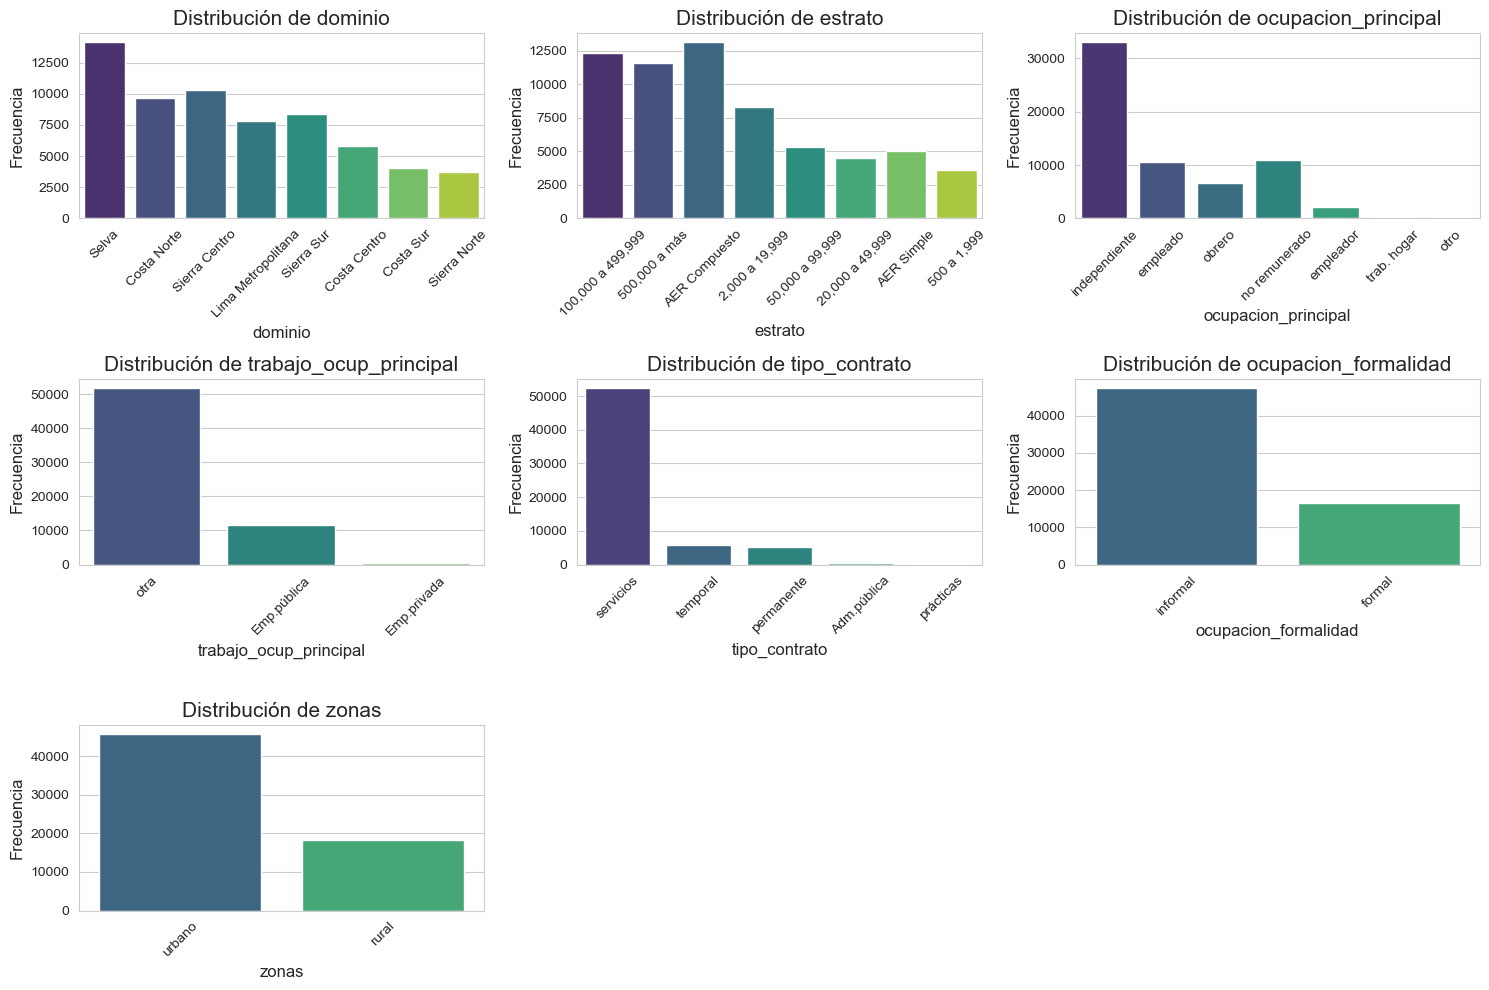

In [104]:
#Seleccionar las variables categóricas a analizar
categorical_vars = df_sin_outliers.select_dtypes('object')

#Definir fondo con líneas
sns.set_style('whitegrid') #fondo con líneas

# Definimos el número de filas y columnas de acuerdo con el número de variables categóricas
num_vars = len(categorical_vars.columns)
num_rows = (num_vars // 2) + (num_vars % 2)  # Dos gráficos por fila

fig, axes = plt.subplots(3, 3, figsize=(15, 10))  # Crear una cuadrícula
fig.subplots_adjust(hspace=0.5) #Espacio entre gráficos(filas)
axes = axes.flatten()  # # Aplanar los ejes para iterar fácilmente
#crear gráficos
for i, var in enumerate(categorical_vars):
    sns.countplot(data=df_sin_outliers, x=var, ax=axes[i], palette='viridis', order=df[var].value_counts().index)
    
    #Establecer título y etiquetas
    axes[i].set_title(f'Distribución de {var}', fontsize = 15)
    axes[i].set_xlabel(var, fontsize = 12)
    axes[i].set_ylabel('Frecuencia', fontsize = 12)
    axes[i].tick_params(axis ='x', rotation = 45)   # Rotar etiquetas para mejor visualización

#Eliminar subplots vacíos:
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
    
#Ajustar diseño de gráfico y mostrar
plt.tight_layout()
plt.show()

Observaciones

#### Crear la variable 'formalidad' usando la 'ocupacion_formalidad' y darle formato entero

* Si es formal = 0
* Si es informal = 1

In [105]:
#Copiar la variable 'ocupacion_formalidad' en 'formalidad' usando copy()
df_sin_outliers['es_formal'] = df_sin_outliers['ocupacion_formalidad'].copy()
df_sin_outliers['es_formal'] = df_sin_outliers['es_formal'].replace({'informal': 1, 'formal': 0})
df_sin_outliers['es_formal'] = df_sin_outliers['es_formal'].astype(int)

#Verificar ambas variables pobreza
print(df_sin_outliers[['ocupacion_formalidad','es_formal']].info())
print(df_sin_outliers[['ocupacion_formalidad','es_formal']].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63829 entries, 0 to 63828
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ocupacion_formalidad  63829 non-null  object
 1   es_formal             63829 non-null  int32 
dtypes: int32(1), object(1)
memory usage: 748.1+ KB
None
ocupacion_formalidad  es_formal
informal              1            47338
formal                0            16491
Name: count, dtype: int64


#### Crear la variable 'estado_pobreza', para analizar la pobreza Monetaria en 2022 , usando la línea de pobreza
* Umbral de pobreza urbano: 415 soles
* Umbral de pobreza rural: 290 soles
    * Si es pobre: 1
    * Si no es pobre: 0

no pobre: 70.61%
pobre: 29.39%


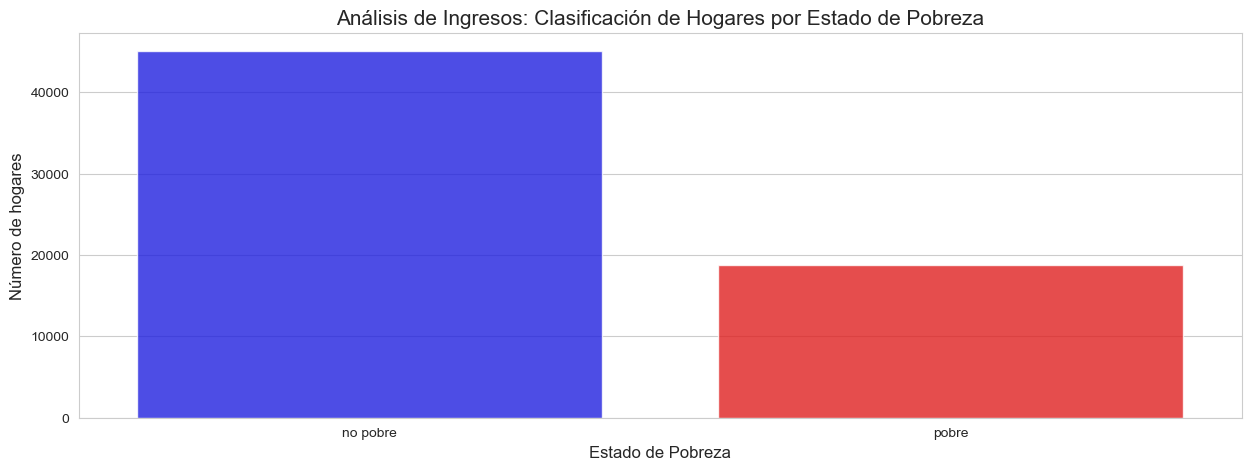

In [106]:
#Crear la vari
# Paso 1: Definir la línea de pobreza
lineas_pobreza = {
    'urbano': {'pobreza': 415},  # Solo una línea para "pobre"
    'rural': {'pobreza': 290}    # Solo una línea para "pobre"
}

# Paso 2: Crear una función para clasificar a los hogares
def clasificar_hogares(row):
    if row['zonas'] == 'urbano':
        linea_pobreza = lineas_pobreza['urbano']['pobreza']
    else:
        linea_pobreza = lineas_pobreza['rural']['pobreza']
    
    # Clasificación: Si el ingreso total es menor que la línea de pobreza, se clasifica como 'Pobre'.
    if row['ingreso_total'] < linea_pobreza:
        return 'pobre'
    else:
        return 'no pobre'

# Paso 3: Aplicar la función
df_sin_outliers['estado_pobreza'] = df_sin_outliers.apply(clasificar_hogares, axis=1)

# Paso 4: Imprimir resumen de la cantidad total de pobreza y porcentaje
pobreza_porcentaje = (df_sin_outliers['estado_pobreza'].value_counts(normalize=True) * 100).round(2)
#iteramos en los resultados
for categoria, porcentaje in pobreza_porcentaje.items():
    print(f"{categoria}: {porcentaje}%")

# Paso 5: Graficar la variable estado pobreza
set_color = ['blue', 'red']
plt.figure(figsize=(15,5))
sns.countplot(x='estado_pobreza', data=df_sin_outliers, palette= set_color, alpha = 0.8)
plt.title("Análisis de Ingresos: Clasificación de Hogares por Estado de Pobreza", fontsize=15)
plt.xlabel('Estado de Pobreza', fontsize=12)
plt.ylabel('Número de hogares', fontsize=12)

# Mostrar la gráfica
plt.show()

##### Crear una variable numérica de pobreza llamada 'es_pobre'
* pobre:1 
* no pobre: 0

In [107]:
#crear una variable numérica de pobreza llamada 'es_pobre', pobre:1 - no pobre: 0
df_sin_outliers['es_pobre'] = df_sin_outliers['estado_pobreza']
df_sin_outliers['es_pobre'] = df_sin_outliers['es_pobre'].replace({'pobre': 1, 'no pobre': 0})
df_sin_outliers['es_pobre'] = df_sin_outliers['es_pobre'].astype(int)

#Mostrar las variables pobreza
print(f'porcentaje de pobreza: {(df_sin_outliers[['estado_pobreza', 'es_pobre']].value_counts(normalize=True)).round(2)*100}')

porcentaje de pobreza: estado_pobreza  es_pobre
no pobre        0           71.0
pobre           1           29.0
Name: proportion, dtype: float64


## 4. Análisis exploratorio de datos (EDA)

#### 4.1. Análisis de relaciones entre variables

* Correlación entre variables numéricas

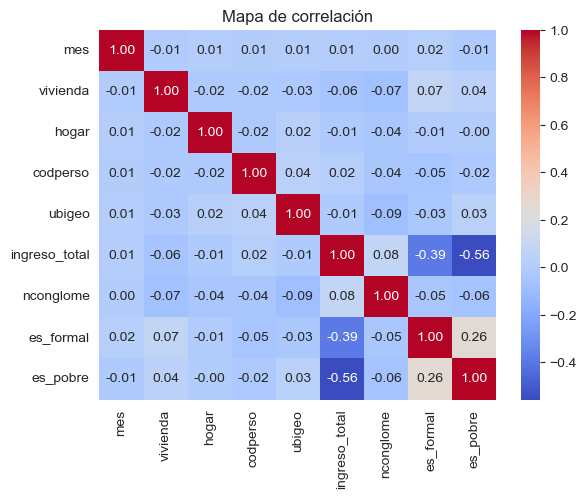

In [108]:
#Seleccionando las variables numericas
var_numericas = df_sin_outliers.select_dtypes('number')
corr = var_numericas.corr()

sns.heatmap(corr, annot=True, cmap = 'coolwarm', fmt='.2f')

plt.title('Mapa de correlación') #Título
plt.show() #Mostrar el gráfico

* Ingreso total (ingreso_total) y pobreza (es_pobre)

    Se observa correlación negativa entre 'ingreso_total' y 'es_pobre' (-0.56) es fuerte, lo que significa que a medida que aumenta el ingreso, disminuye la probabilidad de ser pobre. Esto respalda la teoría de que el ingreso es un factor clave en la pobreza.

* Formalidad de la ocupación (es_formal) y pobreza (es_pobre):

    La correlación entre 'es_formal' y 'es_pobre' es positiva(0.26), lo que sugiere que las personas con ocupaciones formales tienen una menor probabilidad de ser pobres. Sin embargo la correlación es moderada, lo que indica que, aunque la formalidad tienen un efecto positivo en la reducción de la pobreza, no es un factor exclusivo.

* Ingreso total (ingreso_total) y formalidad (es_formal): 

    La correlación negativa (-0.39) entre 'ingreso_total' y 'es_formal', sugiere que a menor ingreso hay más personas en trabajos informales. Esto indica que los trabajos informales están muy correlacionados con bajos niveles de ingreso.

##### Resumen del mapa de calor

La pobreza en la muestra está fuertemente influenciada por el nivel de ingreso, con una correlación negativa entre los ingresos y la pobreza. Además, la informalidad del trabajo también está relacionada con un nivel de ingresos más bajo, lo que, a su vez, aumenta la probabilidad de ser pobre. La ocupación formal, aunque presenta una correlación moderada con la pobreza, puede actuar como un factor protector frente a la pobreza, aunque no es suficiente por sí sola para erradicarla.

* Relaciones entre variables categóricas y numéricas:

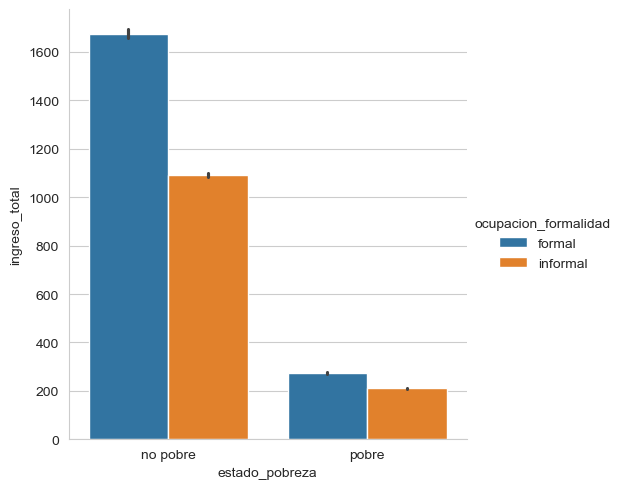

In [109]:
#Observamos la pobreza a través de un gráfico de barras y caja

sns.catplot(kind='bar', x='estado_pobreza', 
            y='ingreso_total', 
            data=df_sin_outliers,
            hue='ocupacion_formalidad')

plt.show()

Este gráfico refuerza la idea que la pobreza está estrechamente relacionada con los ingresos. Además muestra que los trabajos formales generalmente brindan un nivel de ingresos más alto que los trabajos informales, lo que resalta la importancia de las políticas que fomenten la formalización laboral como una posible solución para reducir la pobreza. Sin embargo, también es importante notar que incluso los hogares con ocupaciones formales pueden estar por debajo del umbral de pobreza.

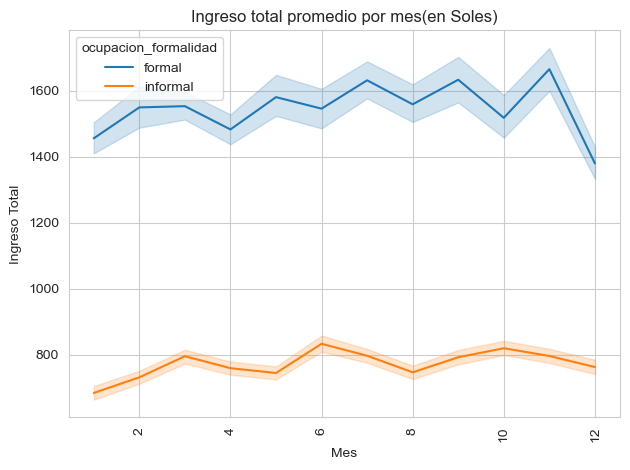

In [110]:
# Gráfico lineal
sns.lineplot(data=df_sin_outliers, x='mes', y='ingreso_total', hue='ocupacion_formalidad')

#Título y ejes
plt.title('Ingreso total promedio por mes(en Soles)')
plt.xlabel('Mes')
plt.ylabel('Ingreso Total')
plt.xticks(rotation = 90)

#Ajustamos el gráfico y lo mostramos
plt.tight_layout()
plt.show()

El gráfico refleja claramente las diferencias en los ingresos entre trabajadores formales e informales a lo largo de los meses del año. La ocupación formal tiene un ingreso promedio más alto y más fluctuante, mientras que los ingresos informales se mantienen bajos y constantes. Esto refuerza la idea de que los trabajadores informales suelen estar en una situación económica más vulnerable, con ingresos más bajos y menos variabilidad, lo que podría reflejar la falta de beneficios adicionales o estabilidad laboral que caracterizan a los trabajos formales.

#### 4.2. Identificar patrones

Las variables con mayor correlación más fuerte son:

* ingreso_total y es_pobre: (-0.56) negativa fuerte
* es_formal y es_pobre: (0.26) positiva moderada.
* ingreso_total y es_formal: (-0.39) negativa moderada.

#### 4.3. Resumen de Insights

* 1. ¿Qué variables parecen ser más importantes?



* 2. ¿Qué problemas existen en los datos?


* 3. ¿Qué patrones interesantes se observan?



In [111]:
#guardamos la data para pasar al análisis exploratorio

#df_sin_outliers.to_csv('dataPobrezaPeru2022.csv',index=False)
